In [16]:
import numpy as np
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from helper.utils import *
import pandas as pd

In [17]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


In [18]:
merged_data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../../dataset/train.tsv')
val_data = read_tsv('../../dataset/val.tsv')
test_data = read_tsv('../../dataset/test.tsv')

In [19]:
X_train, y_train = input_converter(merged_data, train_data)
X_val, y_val = input_converter(merged_data, val_data)
X_test, y_test = input_converter(merged_data, test_data)

In [20]:
df = list_to_dataframe(merged_data)
words = get_unique_words(df)
tags = get_unique_tags(df)

num_words = len(words)
num_tags = len(tags)
max_len = 100

In [21]:
model = blstm_crf_model(num_words, num_tags, max_len)

Model: "crf_model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 50)      1344500     ['inputs[0][0]']                 
                                                                                                  
 spatial_dropout1d_1 (SpatialDr  (None, 100, 50)     0           ['embedding_1[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 100, 128)    58880       ['spatial_dropout1d_1[0

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
num_epoch = 50
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='max',
                                   baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
91/91 [==============================] - 18s 115ms/step - decode_sequence_acc: 0.7079 - loss: 16.6365 - val_decode_sequence_acc: 0.9699 - val_loss: 10.0828
Epoch 2/50
91/91 [==============================] - 8s 86ms/step - decode_sequence_acc: 0.9883 - loss: 3.5116 - val_decode_sequence_acc: 0.9747 - val_loss: 9.6236
Epoch 3/50
91/91 [==============================] - 8s 89ms/step - decode_sequence_acc: 0.9943 - loss: 1.6721 - val_decode_sequence_acc: 0.9759 - val_loss: 9.6755
Epoch 4/50
91/91 [==============================] - 8s 86ms/step - decode_sequence_acc: 0.9960 - loss: 1.1062 - val_decode_sequence_acc: 0.9739 - val_loss: 9.8710
Epoch 5/50
91/91 [==============================] - 8s 87ms/step - decode_sequence_acc: 0.9970 - loss: 0.8450 - val_decode_sequence_acc: 0.9745 - val_loss: 11.6284
Epoch 6/50
91/91 [==============================] - 8s 88ms/step - decode_sequence_acc: 0.9978 - loss: 0.6257 - val_decode_sequence_acc: 0.9741 - val_loss: 13.3441
Epoch 7/50
91/91

In [23]:
print(model.evaluate(X_test, y_test))
model.save('model/blstm_crf.h5')

56/56 [==============================] - 1s 24ms/step - decode_sequence_acc: 0.9742 - loss: 9.9200
[0.9741942882537842, 12.273496627807617]


In [24]:
# just check the oputput
a,b,c,d = model.predict(X_test)
print(b.shape)
y_pred = np.argmax(b, axis=-1)

(1781, 100, 7)


In [25]:
i = np.random.randint(0, X_test.shape[0]) #659
decode_seq, potentials, seq_length, kernel = model.predict(np.array([X_test[i]]))
p = np.argmax(potentials, axis=-1)
y_true = y_test[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)

for w, true, pred in zip(X_test[i], y_true, p[0]):
    if words[w-1] != "ENDPAD":
        print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))

Word                          True      	 Pred

------------------------------------------------------------
@fxatlux                      O         	O
Gmn                           ID        	O
ya                            ID        	ID
,                             O         	O
emg                           ID        	ID
beda                          ID        	ID
pov                           EN        	ID
sebagai                       ID        	ID
fans                          EN        	EN
ya                            ID        	ID
pasti                         ID        	ID
menomorsatukan                ID        	ID
player                        EN        	EN
dr                            ID        	ID
klub                          ID        	ID
idolanya                      ID        	ID
.                             O         	O
Uf                            O         	ID
ketrigger                     MIX-ID-EN 	ID
tri                           O         	EN
sebut          

In [26]:
all_w_pair = []
all_true_pair = []
all_pred_pair = []

for i in range(len(X_test)):
    decode_seq, potentials, seq_length, kernel = model.predict(np.array([X_test[i]]))
    p = np.argmax(potentials, axis=-1)
    y_true = y_test[i]
    w_pair = []
    true_pair = []
    pred_pair = []
    for w, true, pred in zip(X_test[i], y_true, p[0]):
        if words[w-1] != "ENDPAD":
            print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))
            w_pair.append(words[w-1])
            true_pair.append(tags[true])
            pred_pair.append(tags[pred])
    all_w_pair.append(w_pair)
    all_true_pair.append(true_pair)
    all_pred_pair.append(pred_pair)

Cara                          ID        	ID
menghilangkan                 ID        	ID
ovt                           EN        	EN
gimana                        ID        	ID
:D                            O         	O
,                             O         	O
walau                         ID        	ID
udh                           ID        	ID
mule                          ID        	ID
teneg                         ID        	O
tapi                          ID        	ID
ga                            ID        	ID
teneg                         ID        	ID
lagi                          ID        	ID
jadinya                       ID        	ID
(                             O         	O
harusnya                      ID        	ID
ke                            ID        	ID
priv                          EN        	ID
tapi                          ID        	ID
males                         ID        	ID
switch                        EN        	EN
acc                           EN    

In [27]:
true_flat = [item for sublist in all_true_pair for item in sublist]
pred_flat = [item for sublist in all_pred_pair for item in sublist]

              precision    recall  f1-score   support

          ID     0.9130    0.9385    0.9256     22310
          JV     0.8315    0.8651    0.8480      4913
          EN     0.8456    0.8350    0.8403      5018
   MIX-ID-EN     0.9877    0.8253    0.8992       973
   MIX-ID-JV     0.9916    0.8429    0.9112       280
   MIX-JV-EN     0.9339    0.8664    0.8989       277
           O     0.9016    0.8539    0.8771     10153

    accuracy                         0.8954     43924
   macro avg     0.9150    0.8610    0.8858     43924
weighted avg     0.8959    0.8954    0.8951     43924



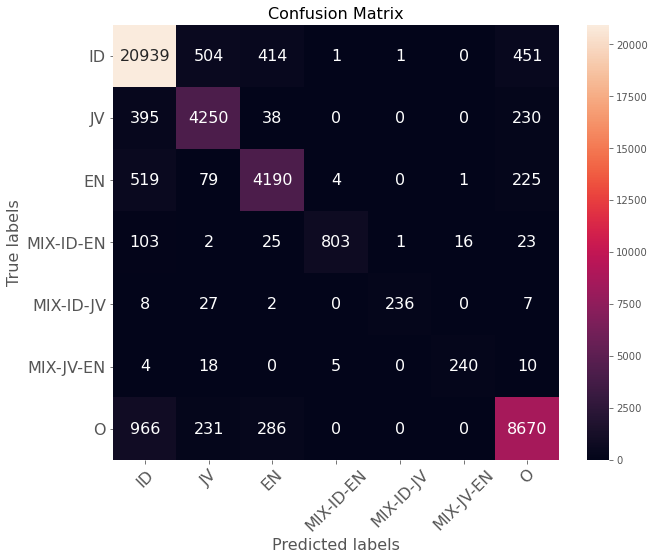

In [28]:
performance_report(true_flat, pred_flat)

In [29]:
df_ = pd.DataFrame({
    'word': all_w_pair,
    'true': all_true_pair,
    'pred': all_pred_pair
})

token_true_pred = []
for index, row in df_.iterrows():
    pair = list(zip(row['word'], row['true'], row['pred']))
    token_true_pred.append(pair)
true_pred_file = 'tagging_result/compare_results_blstm_crf.tsv'

with open(true_pred_file, "a", encoding='utf-8') as f:
    f.write("Word" + "\t" + "True" + "\t" + "Predict" + "\n")

    for index, row in df_.iterrows():
        for tkn, t_true, t_pred in (zip(row['word'], row['true'], row['pred'])):
            f.write(tkn + '\t' + t_true + '\t' + t_pred + '\n')
        f.write('\n')

f.close()


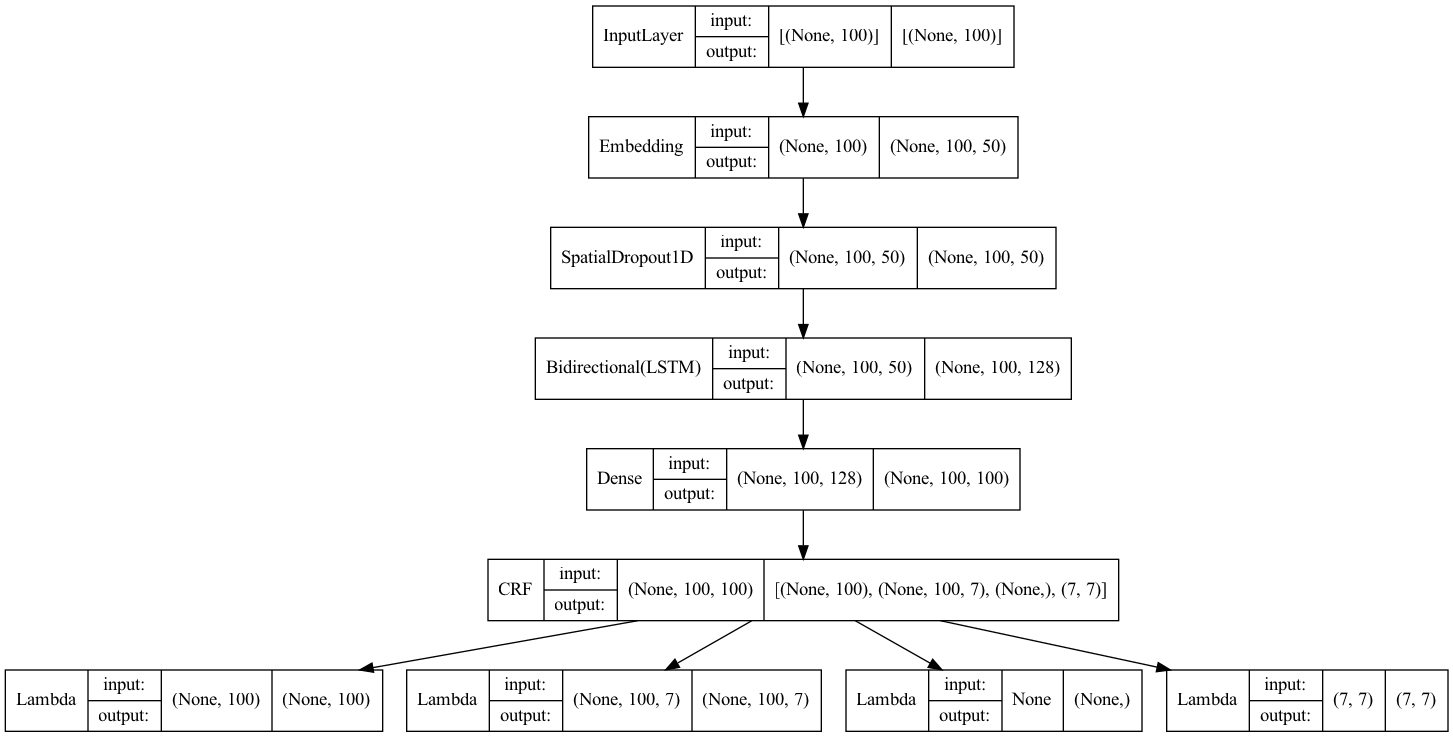

In [30]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot/tr_blstm_crf.png', show_shapes=True, show_layer_names=False)